# 시계열 분석
- 온도, 습도, 기압, 풍향 등 14개 데이터 사용, 10분마다 기록
- 며칠간의 데이터를 입력하고 24시간 이후의 기온 예측
- https://www.kaggle.com/mnassrib/jena-climate

## 드롭아웃, 스태킹, 양방향 순환신경망 사용
- 순환 드롭아웃: 과대적합을 방지
- 스태킹 순환 층: 네트워크의 표현능력을 향상(계산량은 늘어난다)
- 양방향 순환 층: 서로 다른 방향으로 데이터를 입력하여 정확도를 높이고 기억을 오랫동안 유지  

## 데이터
- 독일 Jena시 막스 프랑크 생물지구화학연구소에서 지상 관측소에서 측정한 데이터
- 2009~2016년 데이터 사용

In [1]:
# from google.colab import drive
# drive.mount('drive')

In [2]:
import numpy as np
import pandas as pd
import os, os.path, shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!wget --no-check-certificate \
    https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip \
    -O jena_climate.zip

--2023-09-14 08:30:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.40.96, 52.217.124.248, 52.216.59.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate.zip’

jena_climate.zip    100%[===================>]  12.94M  18.8MB/s    in 0.7s    

2023-09-14 08:30:55 (18.8 MB/s) - ‘jena_climate.zip’ saved [13565642/13565642]



In [4]:
!unzip jena_climate.zip
!ls -1

Archive:  jena_climate.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  
jena_climate_2009_2016.csv
jena_climate.zip
__MACOSX
sample_data


## 데이터프레임으로 읽는 경우
 - easy but takes time and requires large memory


In [5]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.tail(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420450,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


In [6]:
df.shape, df.columns

((420451, 15),
 Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
        'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)'],
       dtype='object'))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [8]:
x = df.drop('Date Time', axis=1).values
x[:3], x.shape

(array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
          9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
          1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
          1.75000e+00,  1.52300e+02],
        [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
          9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
          1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
          1.50000e+00,  1.36100e+02],
        [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
          9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
          1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
          6.30000e-01,  1.71600e+02]]),
 (420451, 14))

## 직접 읽기

In [9]:
# data_dir = './data'
# fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# dataframe 은 속도가 늦음. 파일이 클 경우 csv 파일을 직접 읽을 수 있음.
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [10]:
lines = lines[1:]
print("데이터 사이즈: ", len(lines))

데이터 사이즈:  420451


In [11]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [12]:
x = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]   # 1'st column is the date
    x[i, :] = values

In [13]:
x[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

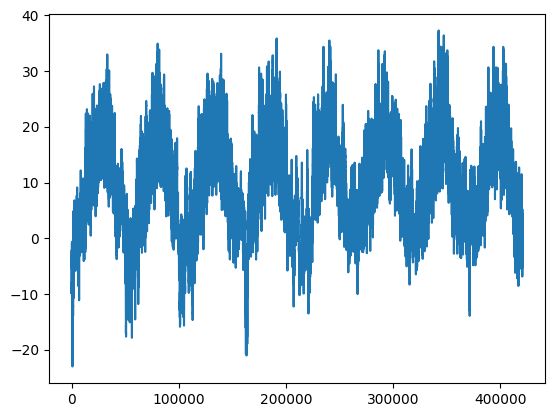

In [14]:
temp = x[:, 1]  # 기온만 그려본다
plt.plot(range(len(temp)), temp)
plt.show()

### 10일간 데이터 만 그려보기
- 샘플은 10분마다 측정
- 스케일링 필요 (데이터 속성이 다름)
- 1440번 측정 (6(samples/hour) * 24(hours) * 10 (days) = 1440 번 측정)
- 선형 예측으로는 불가

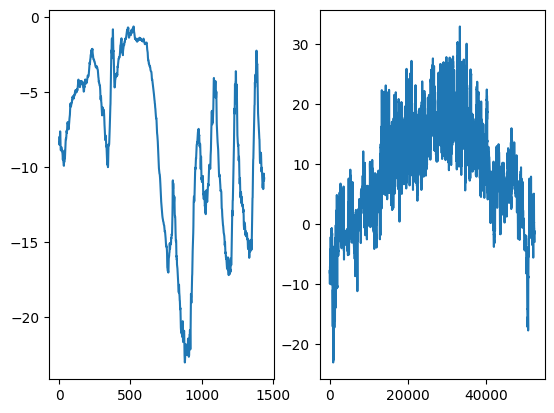

In [15]:
plt.subplot(1,2,1)
plt.plot(range(1440), temp[:1440])    # 10 days
plt.subplot(1,2,2)
plt.plot(range(52560), temp[:52560])  # 12 months ( 1 year)
plt.show()

## 파라미터 준비


* `lookback = 720 (1440)`, 5(10)일간 데이터를 관찰.
* `steps = 6`, 1시간마다 한번 샘플링.
* `delay = 144`, 24시간 후를 예측.

### 준비할 사항

- 데이터 변환 (스케일링): 20만개 훈련 샘플을 사용하여 평균과 표준편차를 계산한다.
- 데이터가 수치형이므로 벡터화는 사용하지 않는다
- 입력 데이터와 레이블을 공급하기 위한 제너레이터를 작성 (입력 데이터를 한 번에 가져오지 않고 필요한 만큼만 메모리에 로드하기 위함): generator 는 (samples, targets) 형태의 값을 생성한다.



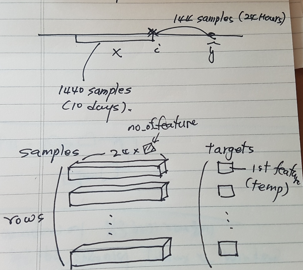

- input shape: batch_size x 240 (previous 10 days) x 14 (features)
- 위 그림 중 24 -> 240

In [16]:
x.shape

(420451, 14)

In [17]:
mean = x[:200000].mean(axis=0)    # scaling using 200000 samples
x -= mean
std = x[:200000].std(axis=0)
x /= std

제너레이터는 (samples, targets) 형태의 값을 생성한다.  sample은 입력의 한 배치를 나타낸다.

제너레이터를 사용하는 이유는 입력 데이터를 모두 한번에 메모리에 미리 로드하지 않기 위해서이다.

아래는 제너레이터 함수의 인자이다:

* `data`: 스케링된 입력 데이터
* `lookback`: 과거의 몇개의 타임스텝을 사용할지 지정
* `delay`: 미래 몇 타임스텝후를 예측할지
* `min_index` and `max_index`: 검증 및 테스트 데이터를 구분하는 경계를 표시
* `shuffle`: 샘플들은 랜덤하게 취할지를 지정
* `batch_size`: 배치 크기
* `step`: 샘플 데이터를 취할 타임스텝수 (여기서는 6)

In [18]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        # rows: 배치 데이터의 기준점 (최대 batch_size 만큼)
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),            # batch_size
                            lookback // step,     # samples for 10 days
                            data.shape[-1]))      # no_of_features
        targets = np.zeros((len(rows),))

        # 배치 데이터의 실제 인덱스
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]  # 1-th feature (temp)
        yield samples, targets

훈련 데이터는 처음 20만개, 검증 데이터는 다음 10만개, 나머지는 테스트 데이터로 사용한다.
SGD를 사용하면 과적합을 피하고, 최적값을 찾아낸 확률이 높아진다.

In [20]:
lookback = 1440  # 사용할 과거의 time step
step = 6         # sample data 를 취할  time step (=6)
delay = 144      # 미래 몇 time step 후를 예측할 지 지정 (24 hours)
batch_size = 128

train_gen = generator(x,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(x,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(x,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(x) - 300001 - lookback) // batch_size

In [21]:
print(next(train_gen)[0].shape)  # samples(batch_size, samples for 10 days, no_of_features)
print(next(train_gen)[1].shape)  # target(batch_size, 1(temp))

(128, 240, 14)
(128,)


In [23]:
next(val_gen)[0].shape, next(val_gen)[1].shape   # batch_size, samples for previous 10 days

((128, 240, 14), (128,))

## 기본 성능 모델

평균치 예측 등, 가장 기본적인 성능을 내는, 최소 기준의 모델을 말한다. 기계학습을 사용하면 적어도 이보다는 성능이 좋아야 한다.
  
여기서는 내일 (24 시간 후)의 날씨는 오늘과 같다고 단순히 예측하는 모델을 사용하겠다. 성능 평가로 절대값 오차를 사용(MAE).

- 아래에 기본 성능 모델의 성능을 계산하였다.

In [26]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]         # batch 데이터의 마지막 날 1-th fature (온도)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


오차 값 0.29는 정규화 한 값이므로 표준 편차(8.8525)를 곱하여 온도의 오차를 구할 수 있다. 온도의 평균 오차는  
2.57˚C이다.

## 간단한 신경망 모델

- 여기서는 두개의 전결합망으로 구성된 MLP을 먼저 만들어보겠다. 성능평가는 MAE를 사용한다.회귀문제이므로 마지막 단은 활성화함수를 사용하지 않는다.

In [29]:
lookback // step, x.shape[-1]

(240, 14)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


<ipython-input-28-1b5b517c1d9a>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 21s 32ms/step - loss: 1.2619 - val_loss: 0.6533
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4377 - val_loss: 0.3236
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2938 - val_loss: 0.3108
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2667 - val_loss: 0.2999
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2534 - val_loss: 0.3229
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2436 - val_loss: 0.3022
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2369 - val_loss: 0.3363
Epoch 8/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2296 - val_loss: 0.3074
Epoch 9/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2248 - val_loss: 0.3274
Epoch 10/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2219 - val_los

훈련과 검증 데이터에 대해서 손실함수 그래프를 그려보겠다.

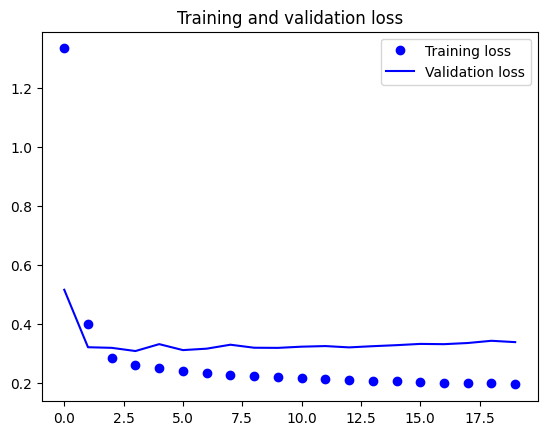

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

앞에서 구한 기본성능 0.29을 얻는 것도 쉽지 않다. 모델로 복잡한 구조를 사용했다고 해서 간단한, 상식적인 모델보다 우수한 성능을 내는 것은 아니다. 모델이 이러한 답을 바로 찾을 수 있다는 보장은 없다. (사람의 직관에 의한 기본 성능을 내는 것도 컴퓨터에게는 어려울 수 있다.)

## 간단한 RNN 모델

앞의 MLP는 시간 정보를 활용하지 못하고 있다. 시퀀스 데이터를 그대로 사용하고 이를 반영하는 모델을 만들어야 한다.

LSTM을 간략히 구현하는 방식인 GRU(gated recurrent unit)을 사용하겠다.

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     input_shape=(None, x.shape[-1]))) # can accept input sequences of varying lengths
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


<ipython-input-41-27a4ef551c95>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 19s 32ms/step - loss: 0.2977 - val_loss: 0.2743
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2849 - val_loss: 0.2680
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2798 - val_loss: 0.2655
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2735 - val_loss: 0.2605
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2709 - val_loss: 0.2628
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2668 - val_loss: 0.2676
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2632 - val_loss: 0.2615
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2604 - val_loss: 0.2697
Epoch 9/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2552 - val_loss: 0.2665
Epoch 10/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2514 - val_los

- 아래 결과를 보면 성능이 나아졌다.

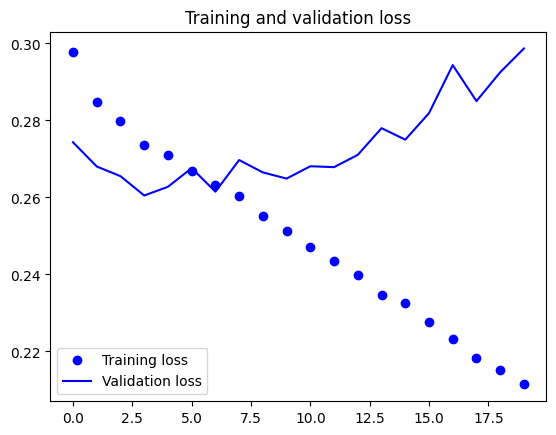

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

MAE 성능이 0.265 (과대 적합하기 시작하는 곳) 정도로 조금 개선되었다.(2.35˚C)  - 기본 모델의 성능이 2.57˚C 였다.

## 과대적합 줄이기

- 몇 번의 이포크 후에 성능이 나빠지므로 과대적합된 것을 알 수 있다. 오랫동안 순환층 이전에 드롭아웃을 사용하면 학습에 방해가 된다고 알려져 왔다.
- 순환네트워크에 드롭아웃을 적절하게 사용하기 위해서는 타임 스텝마다 랜덤하게 드롭아웃 패턴을 바꾸지 않고, 동일한 패턴을 모든 타임 스텝에 적용해야 한다.
- 드롭아웃으로 규제된 네트워크는 완전히 수렴하는데 학습시간이 더 오래 걸린다.


- recurrent_dropout is applied to the recurrent connections between RNN cells.
- (not supported in the cuDNN (CUDA Deep Neural Network library) implementation for GPU acceleration) due to difficulty for parallelization

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     # recurrent_dropout=0.2,
                     input_shape=(None, x.shape[-1]))) # default = 'tanh'
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


<ipython-input-46-b2f7436ea66f>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 19s 33ms/step - loss: 0.3222 - val_loss: 0.2775
Epoch 2/40
500/500 [==============================] - 15s 30ms/step - loss: 0.3023 - val_loss: 0.2725
Epoch 3/40
500/500 [==============================] - 16s 31ms/step - loss: 0.2920 - val_loss: 0.2721
Epoch 4/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2897 - val_loss: 0.2736
Epoch 5/40
500/500 [==============================] - 16s 31ms/step - loss: 0.2852 - val_loss: 0.2755
Epoch 6/40
500/500 [==============================] - 16s 33ms/step - loss: 0.2804 - val_loss: 0.2739
Epoch 7/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2764 - val_loss: 0.2810
Epoch 8/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2723 - val_loss: 0.2807
Epoch 9/40
500/500 [==============================] - 17s 33ms/step - loss: 0.2697 - val_loss: 0.2837
Epoch 10/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2669 - val_los

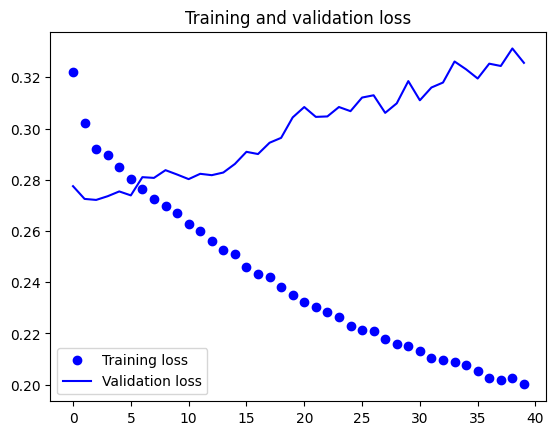

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

과대적합이 발생하지 않았다(?) 성능은 별로 개선되지는 않았다.

## 순환망 쌓기 (Stacking)

이제 과대적합이 되기 전까지는 네트워크의 복잡도(용량)을 늘려서 성능을 개선할 수 있다. 스태킹을 하려면 중간 계층에서는 시퀀스 전체를 출력해야 한다. 이를 위해서 return_sequences=True 로 설정해야 한다.
- remember cuDNN does support only 'tanh' and does not support recirrent_drop_out, resulting in longer train time.

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     # recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x.shape[-1])))
model.add(layers.GRU(64,
                     # activation='relu',
                     dropout=0.1,
                     # recurrent_dropout=0.5
                     ))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

성능을 보겠다.

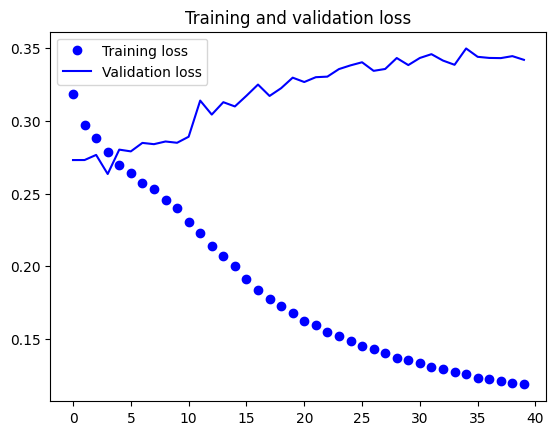

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가해도 성능이 크게 향상되지 않는 것을 알 수 있다.

## 양방향 RNN 시용하기
- 자연어 처리에서 우수한 성능을 낸다. 단방향이 놓치지 쉬운 패턴을 찾아낼 수 있다. 온도 예측의 경우, 성능은 오히려 나빠지는 것을 알 수 있다. - 자연어 처리에서는 성능이 개선되는 경우가 많다 (최근 BERT)
- When using a bidirectional RNN in Keras, most aspects are the same as when using a unidirectional RNN, except for the specific layer that implements bidirectionality.
- can still use 'None' to allow the varying sequence lengths
- The bidirectional RNN layer takes care of processing the input sequences in both directions automatically.

In [ ]:
from tensorflow.keras.layers import Bidirectional, GRU

In [ ]:
model = Sequential()
model.add(Bidirectional(GRU(units=32, input_shape=(None, x.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

<ipython-input-57-d2a770d4d4ce>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/40
500/500 [==============================] - 76s 43ms/step - loss: 0.2989 - val_loss: 0.2756
Epoch 2/40
500/500 [==============================] - 23s 46ms/step - loss: 0.2785 - val_loss: 0.2657
Epoch 3/40
500/500 [==============================] - 24s 48ms/step - loss: 0.2711 - val_loss: 0.2633
Epoch 4/40
500/500 [==============================] - 22s 44ms/step - loss: 0.2670 - val_loss: 0.2642
Epoch 5/40
500/500 [==============================] - 23s 47ms/step - loss: 0.2638 - val_loss: 0.2635
Epoch 6/40
500/500 [==============================] - 23s 45ms/step - loss: 0.2576 - val_loss: 0.2686
Epoch 7/40
500/500 [==============================] - 20s 41ms/step - loss: 0.2536 - val_loss: 0.2671
Epoch 8/40
500/500 [==============================] - 21s 41ms/step - loss: 0.2470 - val_loss: 0.2721
Epoch 9/40
500/500 [==============================] - 20s 39ms/step - loss: 0.2428 - val_loss: 0.2792
Epoch 10/40
500/500 [==============================] - 20s 41ms/step - loss: 0.237

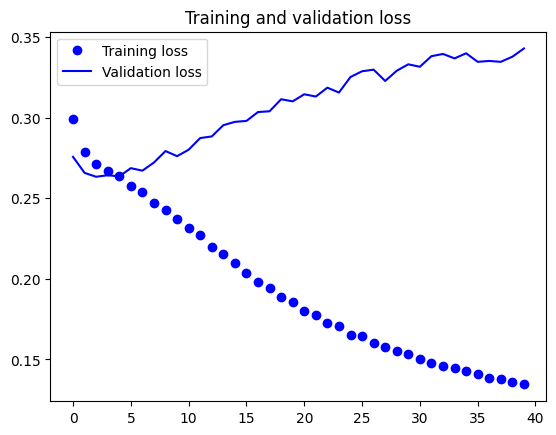

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 연습
- yield: The yield statement suspends function’s execution and sends a value back to the caller, but retains enough state to enable function to resume where it is left off.
- When resumed, the function continues execution immediately after the last yield run.
- This allows its code to produce a series of values over time, rather than computing them at once and sending them back like a list.

In [ ]:
def simpleGenerator(i):
    yield i + 1
    yield i + 2
    yield i + 3

# Driver code to check above generator function
for value in simpleGenerator(5):
    print(value)

6
7
8


In [ ]:
next(simpleGenerator(5))

6

In [ ]:
def nextSquare(j):
    for i in range(j):
        yield i*i

# Driver code to test above generator function
print([value for value in nextSquare(3)])
print([value for value in nextSquare(5)])
for value in nextSquare(3):
    print(value)

[0, 1, 4]
[0, 1, 4, 9, 16]
0
1
4


In [ ]:
def nextSquare2():
    i = 1;

    # An Infinite loop to generate squares
    while True:
        yield i*i
        i += 1  # Next execution resumes
                # from this point

# Driver code to test above generator
# function
for num in nextSquare2():
    if num > 50:
         break
    print(num)

1
4
9
16
25
36
49
